In [1]:
import numpy as np
import math
import random
import warnings
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from scipy.fft import fft, ifft
import scipy.interpolate

import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 7

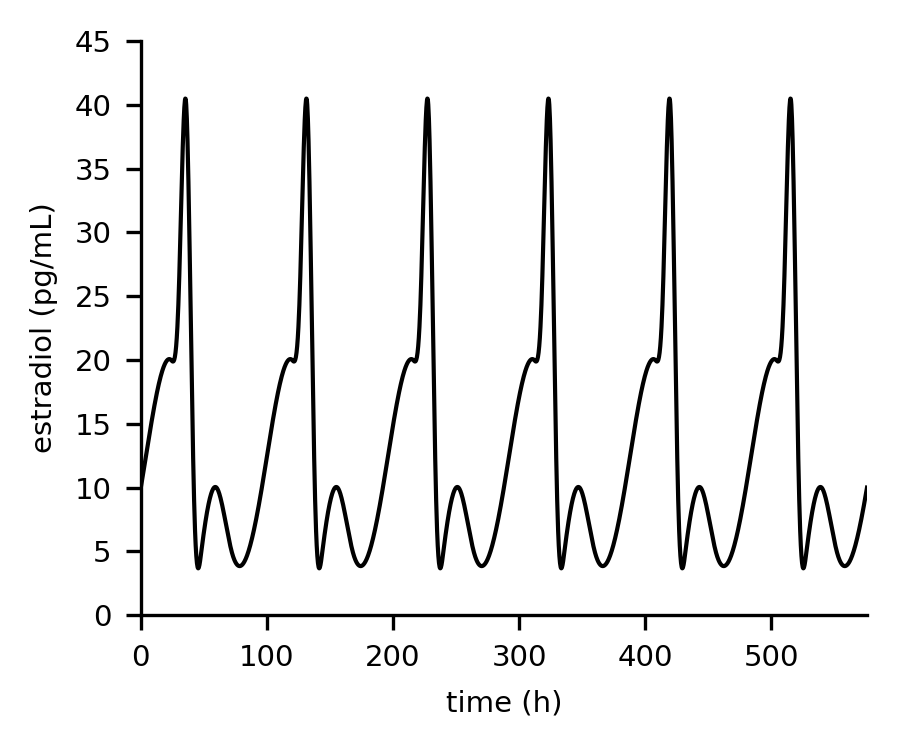

In [19]:
fig, ax = plt.subplots(figsize=(3,2.5), dpi=300)
times = np.arange(0,96*6+.25,0.25)
ax.plot(times, [estradiol_lvl(t) for t in times], color='k', lw=1)
ax.set_ylim([0,45])
ax.set_xlim([0, times[-1]])
ax.set_xlabel('time (h)')
ax.set_ylabel('estradiol (pg/mL)')
fig.tight_layout()
fig.savefig('estradiol_func.svg')

In [33]:
from tqdm import tqdm

In [35]:
# Initial population sizes
init = [1,6,23,2]

# Time grid: from 0 to 20 in steps of 1
# 6 passes through full estrous cycle
times = np.arange(0, 96*6+.25, 0.25)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
res_list = []
for i in tqdm(range(8)):
    res_gillespie_plus = gillespie_plus(init, times, inten, state_change_matrix, nhpp)
    res_list.append(res_gillespie_plus)

  0%|          | 0/8 [00:00<?, ?it/s]/var/folders/nf/336h2vrj3gx4f2_bc7f8p98h0000gn/T/ipykernel_13548/3910395613.py:12: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda x: sum(inten(tottime + x, pops)), 0, X, limit=200)
100%|██████████| 8/8 [1:08:55<00:00, 516.97s/it]


In [69]:
# Initial population sizes
init = [1,6,23,2]

# Time grid: from 0 to 20 in steps of 1
# 6 passes through full estrous cycle
times = np.arange(0, 96*6+.25, 0.25)

# Run simulation using gillespie_plus (nonhomogeneous Poisson process sampler)
res_list1 = []
for i in tqdm(range(8)):
    res_gillespie = gillespie_plus(init, times, inten, state_change_matrix, hpp)
    res_list1.append(res_gillespie)

100%|██████████| 8/8 [00:00<00:00, 10.21it/s]


In [70]:
res_list[0].shape

(2305, 5)

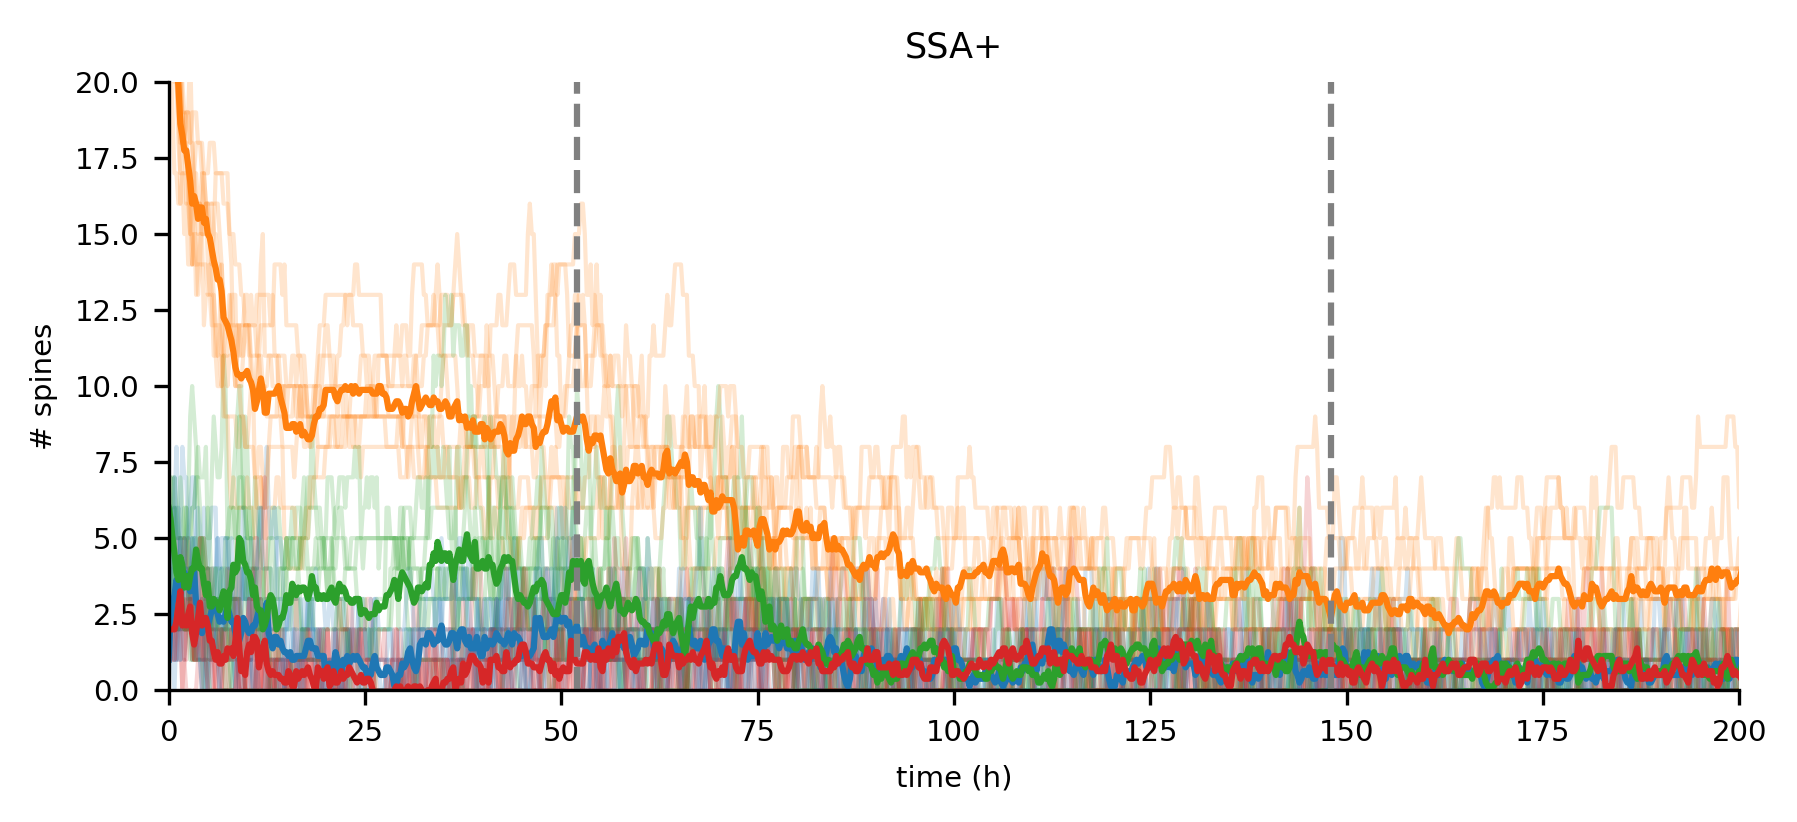

In [121]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list[i]
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.2)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.2)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.2)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.2)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,20])
ax.set_xlim([0,200])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA+')
fig.tight_layout()
fig.savefig('model_runs_x8.svg')

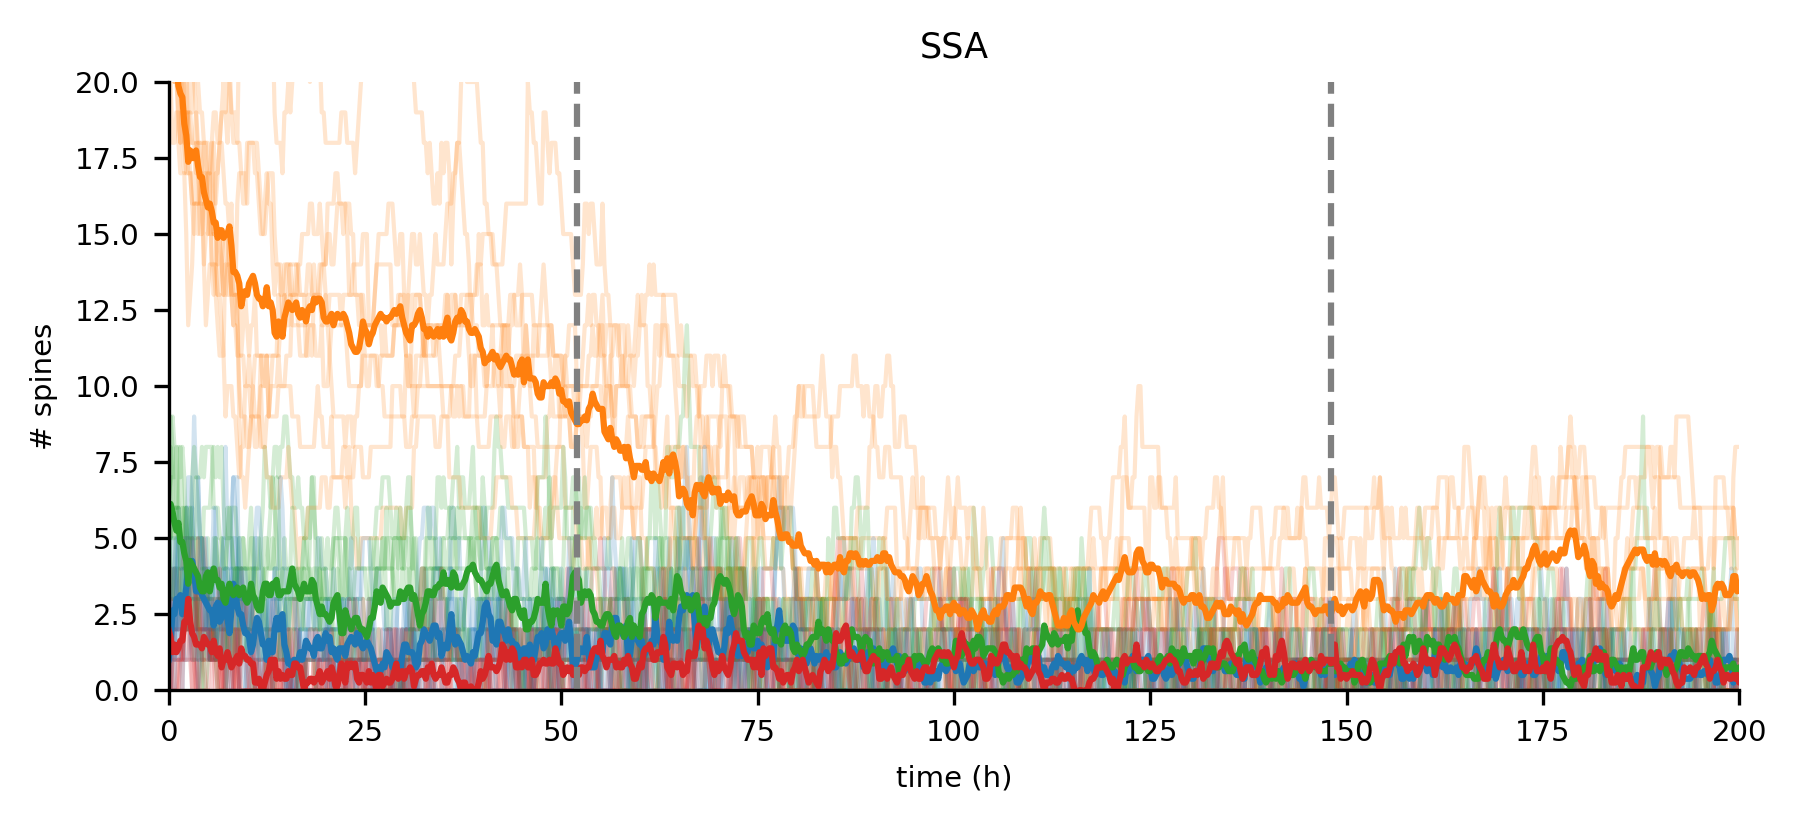

In [123]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list1[i]
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.2)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.2)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.2)
    ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.2)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,20])
ax.set_xlim([0,200])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA')
fig.tight_layout()
fig.savefig('model_runs_homogenous_x8.svg')

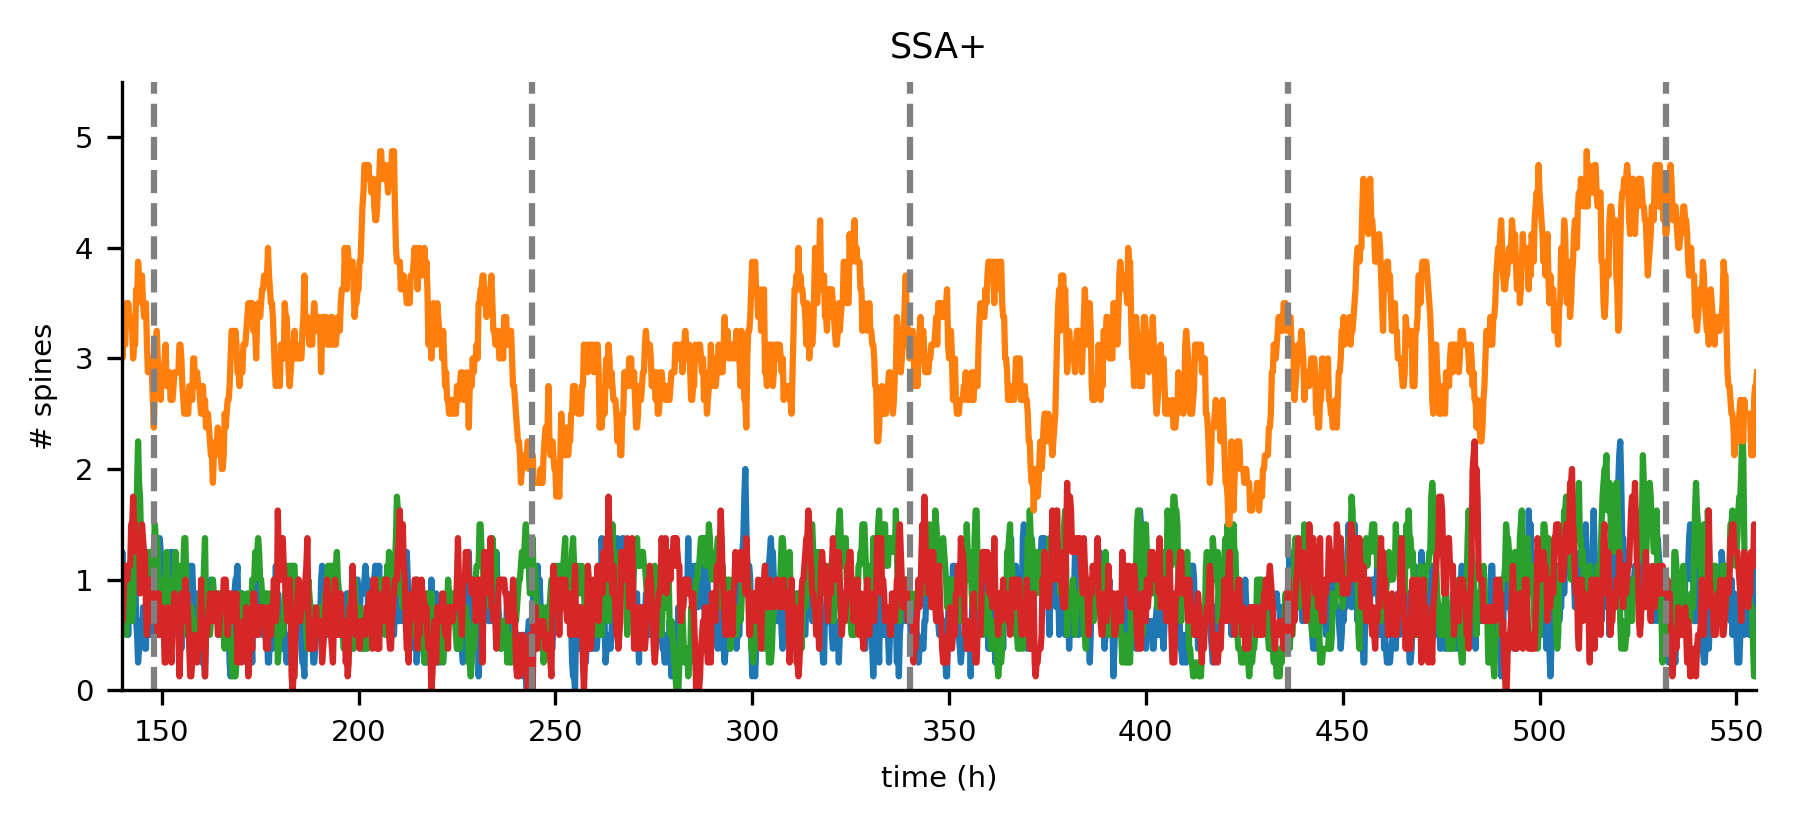

In [124]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list[i]
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.2)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,5.5])
ax.set_xlim([140,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA+')
fig.tight_layout()
fig.savefig('model_runs_x8_long.svg')

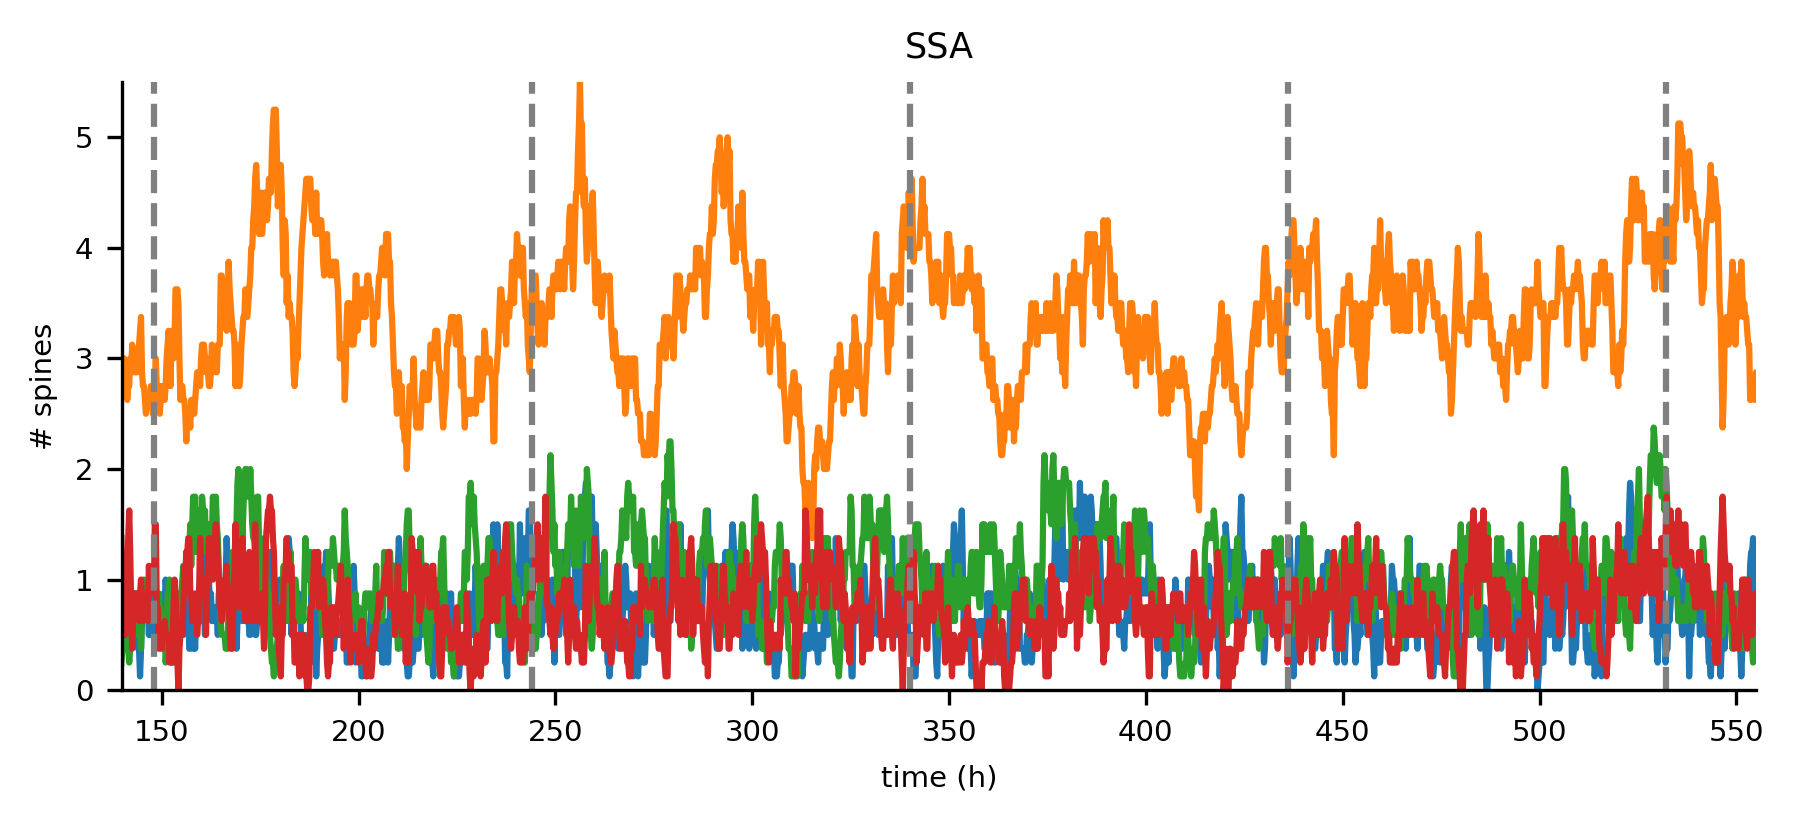

In [125]:
averages = np.zeros([
    np.size(res_list[0],0),
    4,
    8
])

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2.75))
for i in range(8):
    res_gillespie_plus = res_list1[i]
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,1], label='F', lw=1, color='tab:blue', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,2], label='H', lw=1, color='tab:green', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,3], label='S', lw=1, color='tab:orange', alpha=0.2)
    # ax.plot(res_gillespie_plus[:,0], res_gillespie_plus[:,4], label='M', lw=1, color='tab:red', alpha=0.2)

    averages[:,0,i] = res_gillespie_plus[:,1]
    averages[:,1,i] = res_gillespie_plus[:,2]
    averages[:,2,i] = res_gillespie_plus[:,3]
    averages[:,3,i] = res_gillespie_plus[:,4]

ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,0,:], 1), color='tab:blue')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,1,:], 1), color='tab:green')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,2,:], 1), color='tab:orange')
ax.plot(res_gillespie_plus[:,0], np.nanmean(averages[:,3,:], 1), color='tab:red')

ax.vlines(
    res_gillespie_plus[:,0][np.argwhere(res_gillespie_plus[:,0]%96==52).T],
    0,
    20,
    ls='--',
    color='gray'
)

ax.set_ylim([0,5.5])
ax.set_xlim([140,555])
ax.set_xlabel('time (h)')
ax.set_ylabel('# spines')
ax.set_title('SSA')
fig.tight_layout()
fig.savefig('model_runs_homogenous_x8_long.svg')

In [126]:
def negative_log_likelihood(y_true, y_pred, sigma=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    nll = 0.5 * n * np.log(2 * np.pi * sigma**2) + np.sum((y_true - y_pred)**2) / (2 * sigma**2)
    return nll

In [ ]:
for i in range(8):
    res_gillespie_plus = res_list1[i]
    

array([False, False, False, ..., False, False, False])

In [ ]:
negative_log_likelihood(res_gillespie_plus)